# DLS Reading Python Code

# Import packages

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import calendar
from scipy.optimize import curve_fit
#from google.colab import drive
#drive.mount('/content/drive')

# Load Data

In [2]:
#df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-27 - DLS/2023-07-27 lnp.xlsx')
df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-21 - DLS/2023-07-21 LUV + LNP.xlsx')

In [3]:
# choose folder which includes hella DLS files
path = r'/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/Alison DLS'
files = os.listdir(path)

def check_year_zeta(filename):
    if 'zeta' not in filename:
        if '2023' in filename:
            return filename
        elif '2022' in filename:
            return filename

files = list(filter(check_year_zeta, files))

# choose only the excel files
files_xls = [f for f in files if f[-4:] == 'xlsx']

# initiate new dataframe
df = pd.DataFrame()

# open each file and concatenate into df
for f in files_xls:
    
    # open excel file
    xl = pd.ExcelFile(os.path.join(path,f))
    
    # read sheetnames
    if 'Sheet1' in xl.sheet_names:
        sheet_name = 'Sheet1'
    elif 'intensity + number' in xl.sheet_names:
        sheet_name = 'intensity + number'
    else:
        sheet_name = xl.sheet_names[0]
        print("f = " + f)
        print("sheet name = " + sheet_name)
    
    data = pd.read_excel(os.path.join(path,f), sheet_name, header=0)
    data["filename"] = f
    df = pd.concat([df,data])

f = 2022-04-14 POPG LUV + Triton.xlsx
sheet name = 2022-08-19 CF-LUV


## Format df

In [4]:
# remove any columns that include the word Zeta
df = df.drop(columns=df.filter(regex=(r"Zeta")).columns)

In [5]:
# if no measurement date & time, fill with Jan 0, 2000
df["Measurement Date and Time"] = df["Measurement Date and Time"].fillna('Monday, January 1, 2000 12:00:00 AM')

In [6]:
# drop Record Number column
df.drop(columns="Record Number")

# reset index to be unique values
df.reset_index(drop=True, inplace=True)

# make new column called Record Number which includes just unique indices
df["Record Number"] = df.index.values

## Extract Size Data in `size` df

In [7]:
size = df.filter(regex=r'Size').drop_duplicates().dropna().T.reset_index().rename(columns={0:"Diameter (nm)"})
size['DLS index'] = size['index'].str.findall(r'\d+').explode().astype(int)
size['Log Diameter'] = size["Diameter (nm)"].apply("log10")
size = size.drop(columns='index')
size

,Diameter (nm),DLS index,Log Diameter
0,0.4000,1,-0.397940
1,0.4632,2,-0.334231
2,0.5365,3,-0.270430
3,0.6213,4,-0.206699
4,0.7195,5,-0.142969
...,...,...,...
65,5560.0000,66,3.745075
66,6439.0000,67,3.808818
67,7456.0000,68,3.872506
68,8635.0000,69,3.936262


## Format sample names and dates in `info` df

In [8]:
info = pd.DataFrame(df.loc[:,['Measurement Date and Time','Sample Name','Record Number']].copy(deep=True))
info['Triplicate'] = info['Sample Name'].str.strip().str[-1]
info['title'] = info['Sample Name'].str.rstrip(r'123 ')

# extract date and time information
info = info.join(pd.DataFrame(info["Measurement Date and Time"].str.findall(r'([A-Z][a-z]*), ([A-Z][a-z]*) (\d\d?), (\d{4}) (\d\d?:\d\d?:\d\d [AP]M)').explode().to_list(), columns=["day of week","month","day","year","time"]))

# replace string month to numerical month to be read by datetime function
d = dict((v,k) for k,v in enumerate(calendar.month_name))
info["month"] = info.month.map(d)

# convert columns to integer datatype
info["day"] = info["day"].astype(int)
info["month"] = info["month"].astype(int)
info["year"] = info["year"].astype(int)

# convert month/day/year into datetime format
info["date"] = pd.to_datetime(info.loc[:,["year","month","day"]])

# remove month/date/year columns
info.drop(columns=['year','month','day','day of week'], inplace=True)

info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date
0,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,0,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01
1,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 2,1,2,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01
2,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 3,2,3,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01
3,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 1,3,1,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01
4,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 2,4,2,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01


## Find all unique titles and dates in `info`. Save to `samples` dataframe and generate unique sample `id`. 

In [9]:
samples = info.loc[:,["title","date"]].drop_duplicates()

In [10]:
samples["id"] = np.arange(0,samples.shape[0])
samples.head()

,title,date,id
0,1X CF-LUV eluted in 1X PBS pH 5.5,2000-01-01,0
3,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,2000-01-01,1
6,POPC-LUV extruded 200 nm,2000-01-01,2
9,N:P 1:1 LNP 0.1X,2023-03-01,3
12,N:P 5:1 LNP 0.1X,2023-03-02,4


## Compute days since first sample for each unique title

In [11]:
# new startdate pivot table with earliest date for each unique title
startdate = pd.pivot_table(data=samples,
               index="title",
               values="date",
               aggfunc="min").rename(columns={"date" : "start date"})

In [12]:
# add back in to samples and compute days since 'start date'
samples = samples.merge(startdate, left_on="title",right_on="title")
samples["days since"] = samples["date"] - samples["start date"]
samples["days since"] = samples["days since"].apply(lambda x: x.days)

In [13]:
# return info back to `info` dataframe
info = info.merge(samples, 
           left_on=["title","date"],
           right_on=["title","date"]
          )
info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date,id,start date,days since
0,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,0,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
1,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 2,1,2,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
2,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 3,2,3,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
3,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 1,3,1,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01,1,2000-01-01,0
4,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 2,4,2,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01,1,2000-01-01,0


## Create intensity dataframe

In [14]:
intensity = df.filter(regex=r'Record Number|Intensities').set_index('Record Number').T
intensity['DLS index'] = pd.Series(intensity.index).str.findall(r'\d+').explode().values.astype(int)

# drop any rows for which there are nan values
intensity = intensity.dropna(axis=1)
intensity.head(3)

Record Number,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,DLS index
Intensities[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Intensities[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Intensities[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Create number dataframe

In [15]:
number = df.filter(regex=r'Record Number|Numbers').set_index('Record Number').T
number['DLS index'] = pd.Series(number.index).str.findall(r'\d+').explode().values

# drop any rows for which there are nan values
number = number.dropna(axis=1)
number.head(3)

Record Number,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,DLS index
Numbers[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Numbers[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Numbers[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Join `intensity`, `number`, `size`, and `info` to `df_main`

In [16]:
df_main = intensity.melt(id_vars='DLS index', value_vars=intensity.columns, value_name='Intensity %')
print(df_main.shape)
df_main.head(3)

(37380, 3)


,DLS index,Record Number,Intensity %
0,1,0,0.0
1,2,0,0.0
2,3,0,0.0


In [17]:
df_main = df_main.join(number.melt(id_vars='DLS index', value_vars=number.columns, value_name='Number %').loc[:,"Number %"])
print(df_main.shape)
df_main.head(3)

(37380, 4)


,DLS index,Record Number,Intensity %,Number %
0,1,0,0.0,0.0
1,2,0,0.0,0.0
2,3,0,0.0,0.0


In [18]:
df_main = df_main.merge(size, left_on="DLS index", right_on="DLS index")
print(df_main.shape)
df_main.head(3)

(37380, 6)


,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter
0,1,0,0.0,0.0,0.4,-0.39794
1,1,1,0.0,0.0,0.4,-0.39794
2,1,2,0.0,0.0,0.4,-0.39794


In [19]:
df_main = df_main.merge(info, left_on="Record Number", right_on="Record Number")
print(df_main.shape)
df_main.head(3)

(37380, 15)


,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,title,time,date,id,start date,days since
0,1,0,0.0,0.0,0.4000,-0.397940,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
1,2,0,0.0,0.0,0.4632,-0.334231,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
2,3,0,0.0,0.0,0.5365,-0.270430,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0


# Extract LUV/LNP Parameters from Title
fluorophore, LUV, LNP, lipid, lipidoid, pH

In [20]:
df_main["LUV"] = df_main["title"].str.count(r'LUV')

In [21]:
df_main["LNP"] = df_main["title"].str.count(r'LNP')

In [22]:
df_test = df_main["title"].str.findall(r'R18 \+ CF|R18|CF').explode()
df_test = df_test[~df_test.index.duplicated(keep='first')]
df_main["fluorophore"] = df_test

In [23]:
df_main["lipid"] = df_main["title"].str.findall(r'(POPC|POPG)').explode()
df_main["lipid"] = df_main["lipid"].fillna('POPC')

In [24]:
df_main["lipidoid"] = df_main["title"].str.findall(r'\d{3}\w{1,2}10').explode()

In [25]:
df_main["pH"] = df_main["title"].str.findall(r'pH (5.5|7.4)').explode()
df_main["pH"] = df_main["pH"].fillna('7.4')

In [26]:
df_main["Triton"] = df_main["title"].str.count(r'Triton')

# Save dataframe!

In [27]:
df_main.to_excel('data/df_main.xlsx', sheet_name='all data')

# Plot DLS Data

## Plot LUV by type of lipid for samples with no Triton

In [28]:
df_main["lipid"].dropna().unique()

array(['POPC', 'POPG'], dtype=object)

POPC
POPG


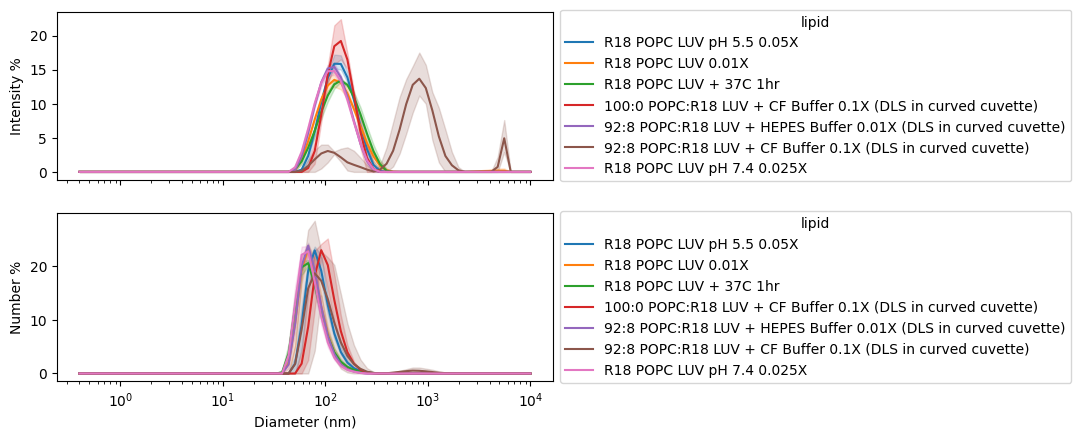

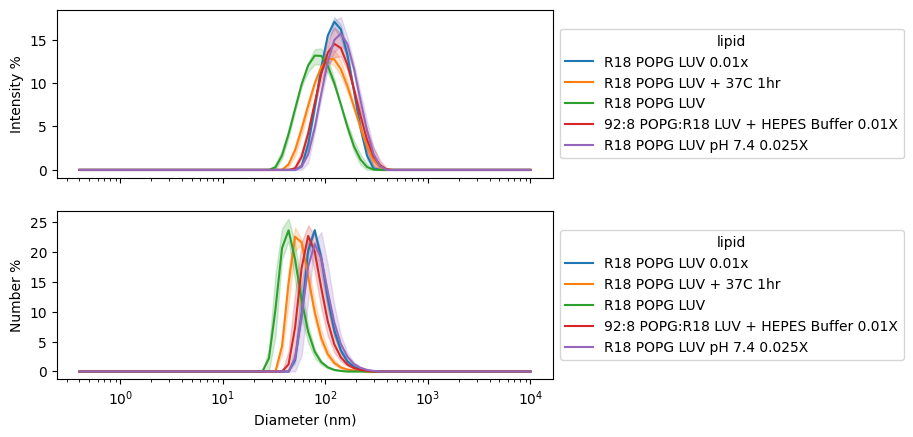

In [29]:
LUV = 1
lipid = "POPC"
fluorophore = "R18"
pH = "5.5"
Triton = 0

temp_data = df_main[(df_main["LUV"] == LUV) &
                    (df_main["fluorophore"] == fluorophore) &
                    #(df_main["pH"] == pH) &
                    (df_main["Triton"] == Triton)]

for lipid in temp_data["lipid"].dropna().unique():
    print(lipid)
    
    fig, ax = plt.subplots(2,1, sharex=True)

    sns.lineplot(data=temp_data[temp_data["lipid"] == lipid],
                 x="Diameter (nm)",
                 y="Intensity %",
                 hue="title",
                 ax=ax[0])

    sns.lineplot(data=temp_data[temp_data["lipid"] == lipid],
                 x="Diameter (nm)",
                 y="Number %",
                 hue="title",
                 ax=ax[1])

    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipid")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipid")

    ax[0].set_xscale('log')

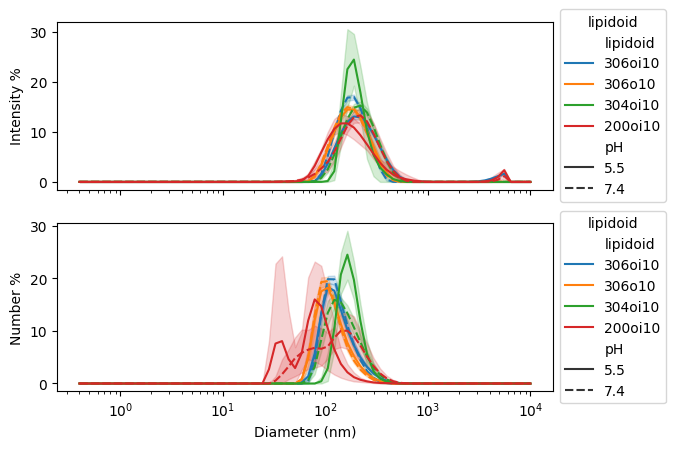

In [30]:
fig, ax = plt.subplots(2,1, sharex=True)

temp_data = df_main[df_main['lipidoid'].notna()]

sns.lineplot(data=temp_data,
             x="Diameter (nm)",
             y="Intensity %",
             hue="lipidoid",
             style="pH",
             ax=ax[0])

sns.lineplot(data=temp_data,
             x="Diameter (nm)",
             y="Number %",
             hue="lipidoid",
             style="pH",
             ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipidoid")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipidoid")

ax[0].set_xscale('log')

# Compute Peak Diameter (mode) for each `id` 

In [31]:
# aggfunc finds the index of the maximum value for intensity and number columns, then uses index to find the diameter at which the max is found
df_pivot = pd.pivot_table(data=df_main,
               index='id',
               values = ["Intensity %","Number %"],
               aggfunc = [lambda x: df_main.loc[x.idxmax(0),"Diameter (nm)"]]
              )

In [32]:
# format column names
df_pivot.columns = ["Peak Diameter by " + a[1] for a in df_pivot.columns.to_flat_index()]

df_pivot

,Peak Diameter by Intensity %,Peak Diameter by Number %
id,,
0,122.4,78.82
1,122.4,78.82
2,190.1,50.75
3,141.8,78.82
4,141.8,105.70
...,...,...
175,122.4,78.82
176,122.4,68.06
177,190.1,78.82


In [33]:
# merge back in to df_main
df_main = df_main.merge(df_pivot, left_on="id", right_on="id")
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,title,...,days since,LUV,LNP,fluorophore,lipid,lipidoid,pH,Triton,Peak Diameter by Intensity %,Peak Diameter by Number %
0,1,0,0.0,0.0,0.4000,-0.397940,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,1,0,CF,POPC,NaN,5.5,0,122.4,78.82
1,2,0,0.0,0.0,0.4632,-0.334231,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,1,0,CF,POPC,NaN,5.5,0,122.4,78.82
2,3,0,0.0,0.0,0.5365,-0.270430,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,1,0,CF,POPC,NaN,5.5,0,122.4,78.82
3,4,0,0.0,0.0,0.6213,-0.206699,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,1,0,CF,POPC,NaN,5.5,0,122.4,78.82
4,5,0,0.0,0.0,0.7195,-0.142969,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,1,0,CF,POPC,NaN,5.5,0,122.4,78.82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37375,66,556,0.0,0.0,5560.0000,3.745075,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,1,0,CF,POPC,NaN,7.4,0,122.4,78.82
37376,67,556,0.0,0.0,6439.0000,3.808818,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,1,0,CF,POPC,NaN,7.4,0,122.4,78.82
37377,68,556,0.0,0.0,7456.0000,3.872506,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,1,0,CF,POPC,NaN,7.4,0,122.4,78.82
37378,69,556,0.0,0.0,8635.0000,3.936262,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,1,0,CF,POPC,NaN,7.4,0,122.4,78.82


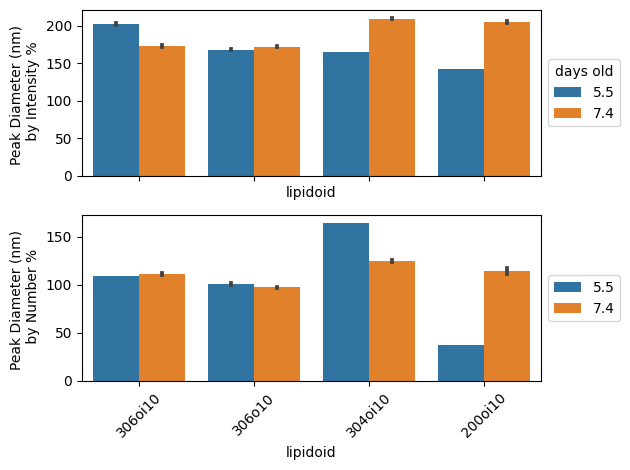

In [34]:
fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=df_main,
            x="lipidoid",
            y="Peak Diameter by Intensity %",
            hue="pH",
           ax=ax[0])

ax[0].set_ylabel('Peak Diameter (nm) \n by Intensity %')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=df_main,
            x="lipidoid",
            y="Peak Diameter by Number %",
            hue="pH",
            ax=ax[1])

ax[1].set_ylabel('Peak Diameter (nm) \n by Number %')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.xticks(rotation = 45)

plt.tight_layout()

# Compute weighted average intensity and number

In [35]:
# prepare temporary dataframe for calculation
df_rn = pd.DataFrame(df_main["Record Number"].drop_duplicates()).set_index("Record Number")

# for each unique record number, compute the weighted average intensity and number
for rn in df_rn.index:
    rn_sum_prod_int = df_main.loc[df_main["Record Number"] == rn].loc[:,["Intensity %","Diameter (nm)"]].product(axis=1).sum()
    rn_sum_prod_num = df_main.loc[df_main["Record Number"] == rn].loc[:,["Number %","Diameter (nm)"]].product(axis=1).sum()
    rn_sum_weights_int = df_main.loc[df_main["Record Number"] == rn].loc[:,["Intensity %"]].sum().values
    rn_sum_weights_num = df_main.loc[df_main["Record Number"] == rn].loc[:,["Number %"]].sum().values

    # assign value in df_rn
    df_rn.loc[rn,"Weighted Average Intensity"] = rn_sum_prod_int / rn_sum_weights_int
    df_rn.loc[rn,"Weighted Average Number"] = rn_sum_prod_num / rn_sum_weights_num

# merge back in to df_main  
df_main = df_main.merge(df_rn, left_on="Record Number", right_on=df_rn.index)
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,title,...,LNP,fluorophore,lipid,lipidoid,pH,Triton,Peak Diameter by Intensity %,Peak Diameter by Number %,Weighted Average Intensity,Weighted Average Number
0,1,0,0.0,0.0,0.4000,-0.397940,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,CF,POPC,NaN,5.5,0,122.4,78.82,124.268148,84.265125
1,2,0,0.0,0.0,0.4632,-0.334231,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,CF,POPC,NaN,5.5,0,122.4,78.82,124.268148,84.265125
2,3,0,0.0,0.0,0.5365,-0.270430,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,CF,POPC,NaN,5.5,0,122.4,78.82,124.268148,84.265125
3,4,0,0.0,0.0,0.6213,-0.206699,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,CF,POPC,NaN,5.5,0,122.4,78.82,124.268148,84.265125
4,5,0,0.0,0.0,0.7195,-0.142969,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,...,0,CF,POPC,NaN,5.5,0,122.4,78.82,124.268148,84.265125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37375,66,556,0.0,0.0,5560.0000,3.745075,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,CF,POPC,NaN,7.4,0,122.4,78.82,129.480410,88.898232
37376,67,556,0.0,0.0,6439.0000,3.808818,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,CF,POPC,NaN,7.4,0,122.4,78.82,129.480410,88.898232
37377,68,556,0.0,0.0,7456.0000,3.872506,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,CF,POPC,NaN,7.4,0,122.4,78.82,129.480410,88.898232
37378,69,556,0.0,0.0,8635.0000,3.936262,"Wednesday, October 19, 2022 7:12:08 PM",Sample C - CF-LUV + PBS (avg),),Sample C - CF-LUV + PBS (avg),...,0,CF,POPC,NaN,7.4,0,122.4,78.82,129.480410,88.898232


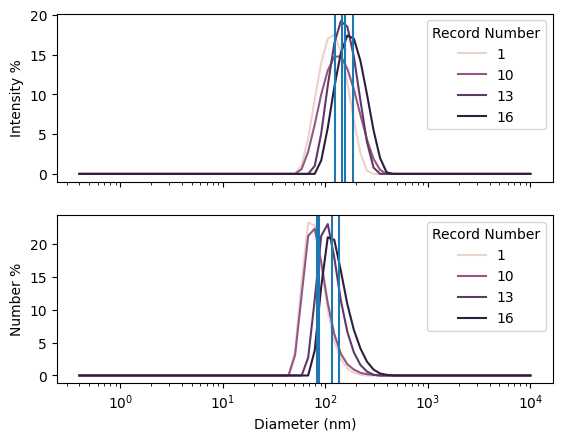

In [36]:
fig, ax = plt.subplots(2,1,sharex=True)

sns.lineplot(data=df_main[df_main["Record Number"].isin([1,10,13,16])],
             x="Diameter (nm)",
             y="Intensity %",
             hue="Record Number",
             ax=ax[0])

for rn in [1,10,13,16]:
    ax[0].axvline(x=df_main[df_main["Record Number"] == rn].loc[:,"Weighted Average Intensity"].drop_duplicates().values)
    
sns.lineplot(data=df_main[df_main["Record Number"].isin([1,10,13,16])],
             x="Diameter (nm)",
             y="Number %",
             hue="Record Number",
             ax=ax[1])

for rn in [1,10,13,16]:
    ax[1].axvline(x=df_main[df_main["Record Number"] == rn].loc[:,"Weighted Average Number"].drop_duplicates().values)


ax[0].set_xscale('log')



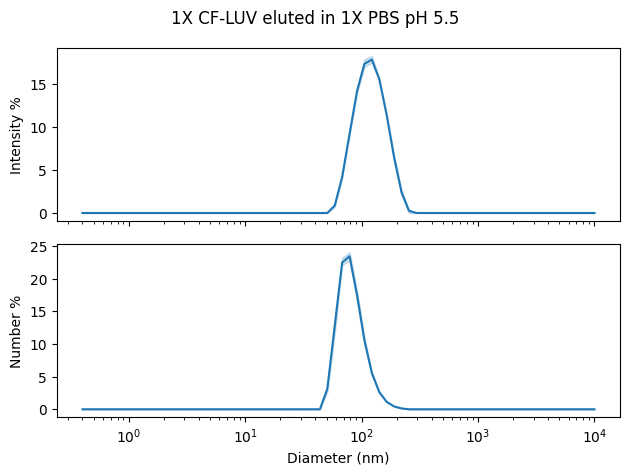

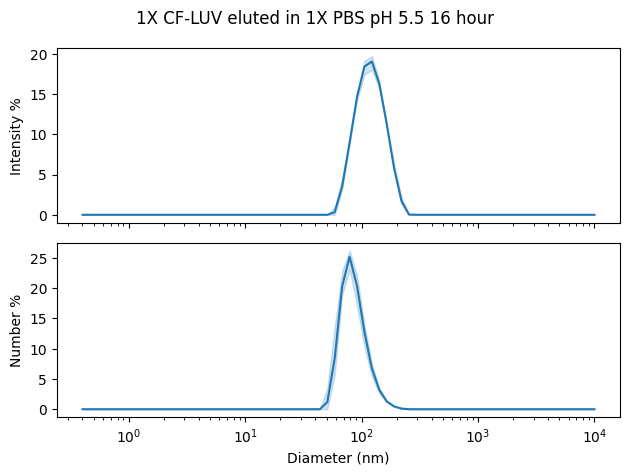

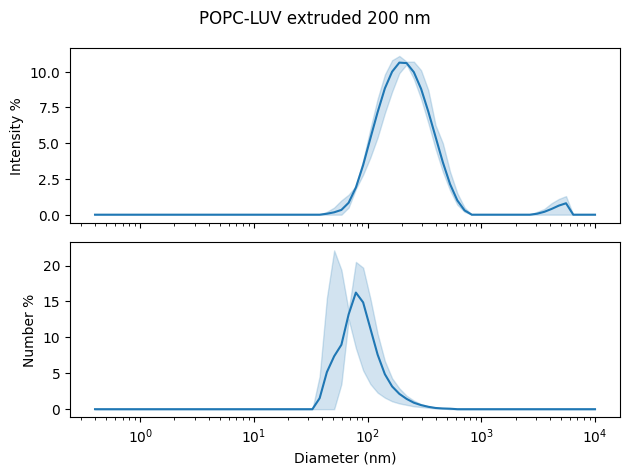

In [37]:
for title in df_main["title"].unique()[0:3]:

    fig, ax = plt.subplots(2,1,sharex=True)

    sns.lineplot(data=df_main[df_main["title"] == title],
                 x="Diameter (nm)",
                 y="Intensity %",
                 ax=ax[0])

    sns.lineplot(data=df_main[df_main["title"] == title],
                 x="Diameter (nm)",
                 y="Number %",
                 ax=ax[1])

    ax[0].set_xscale('log')
    plt.suptitle(title)
    plt.tight_layout()



/var/folders/hw/0c_7gpv502zb91jv54cs9tmc0000gn/T/ipykernel_2022/784787728.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


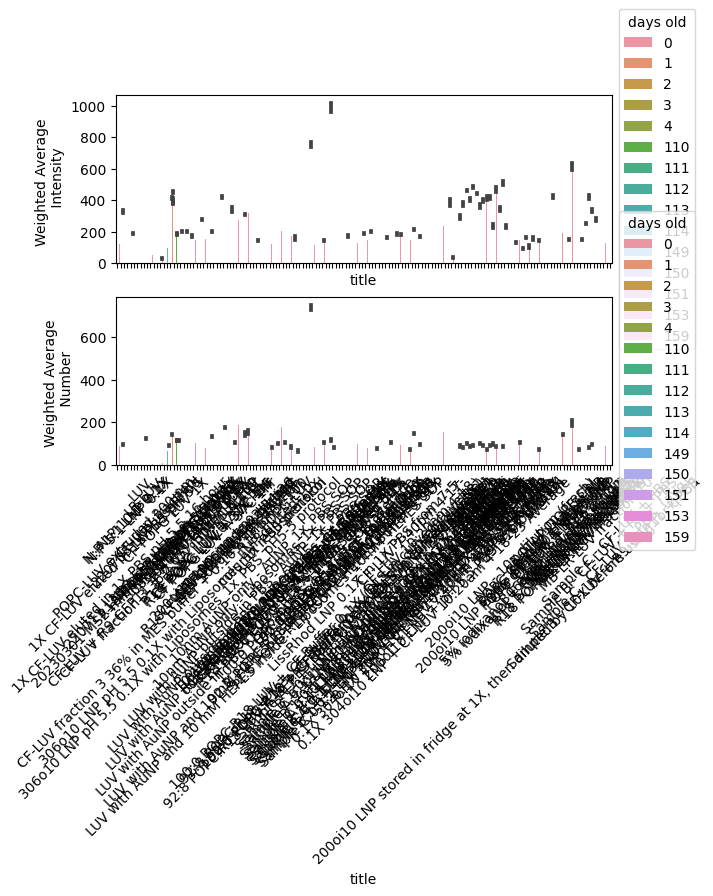

In [38]:
fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=df_main,
            x="title",
            y="Weighted Average Intensity",
            hue="days since",
           ax=ax[0])

ax[0].set_ylabel('Weighted Average \n Intensity')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=df_main,
            x="title",
            y="Weighted Average Number",
            hue="days since",
            ax=ax[1])

ax[1].set_ylabel('Weighted Average \n Number')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

plt.xticks(rotation = 45)

plt.tight_layout()

# Fit Gaussian to curves

## Generate fitted parameters (a, x0, sigma)

In [39]:
# Define Gaussian function that we will fit to
def Gauss(x, a, x0, sigma):
    # a = maximum 
    # x0 = mean
    # sigma = standard of deviation
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# initial guess for data
p0_guess = p0=[10,2,1]

In [40]:
for rn in df_rn.index:
    
    for datatype in ["Intensity","Number"]:

        # extract dataframe for this record number
        df_temp = df_main.loc[df_main["Record Number"]==rn].loc[:,["Log Diameter",datatype + " %"]].copy(deep=True)

        # Execute Curve Fit
        popt, pcov = curve_fit(Gauss, 
                               df_temp["Log Diameter"].values, 
                               df_temp[datatype + " %"].values,
                               p0=p0_guess)

        # load Optimized values into df_rn
        df_rn.loc[rn,["a "+datatype,"log10 x0 "+datatype,"log10 sigma "+datatype]] = popt
        
        # generate new fitted data
        yfit = Gauss(df_temp["Log Diameter"].values, 
                     popt[0], popt[1], popt[2])
        
        # load into df_temp, then join with df_main
        df_main.loc[df_temp.index,"Fitted "+datatype+" %"] = yfit

In [41]:
# calculate and load confidence interval data into df_rn
for datatype in ["Intensity","Number"]:
    # convert x0 and sigma back to linear space
    df_rn.loc[:,"x0 "+datatype]    = np.power(10,df_rn.loc[:,"log10 x0 " + datatype])
    df_rn.loc[:,"sigma "+datatype] = np.power(10,df_rn.loc[:,"log10 sigma " + datatype])

    # calculate lower and upper bounds of confidence interval
    df_rn.loc[:,"lower "+datatype] = np.power(10, df_rn.loc[:,"log10 x0 " + datatype] - df_rn.loc[:,"log10 sigma " + datatype])
    df_rn.loc[:,"upper "+datatype] = np.power(10, df_rn.loc[:,"log10 x0 " + datatype] + df_rn.loc[:,"log10 sigma " + datatype])

    # calculate lower and upper error bars of confidence interval
    df_rn.loc[:,"lower err "+datatype] = df_rn.loc[:,"x0 "+datatype]      - df_rn.loc[:,"lower "+datatype]
    df_rn.loc[:,"upper err "+datatype] = df_rn.loc[:,"upper "+datatype] - df_rn.loc[:,"x0 "+datatype]

In [42]:
# merge all that new confidence interval information into df_main
df_main = df_main.merge(df_rn, left_on="Record Number", right_on=df_rn.index)

In [43]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %',
       'Peak Diameter by Number %', 'Weighted Average Intensity_x',
       'Weighted Average Number_x', 'Fitted Intensity %', 'Fitted Number %',
       'Weighted Average Intensity_y', 'Weighted Average Number_y',
       'a Intensity', 'log10 x0 Intensity', 'log10 sigma Intensity',
       'a Number', 'log10 x0 Number', 'log10 sigma Number', 'x0 Intensity',
       'sigma Intensity', 'lower Intensity', 'upper Intensity',
       'lower err Intensity', 'upper err Intensity', 'x0 Number',
       'sigma Number', 'lower Number', 'upper Number', 'lower err Number',
       'upper err Number'],
      dtype='object')

# Bar Graphs of Peak, Weighted Mean Diameter, and Fitted Mean Diameter

In [44]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %',
       'Peak Diameter by Number %', 'Weighted Average Intensity_x',
       'Weighted Average Number_x', 'Fitted Intensity %', 'Fitted Number %',
       'Weighted Average Intensity_y', 'Weighted Average Number_y',
       'a Intensity', 'log10 x0 Intensity', 'log10 sigma Intensity',
       'a Number', 'log10 x0 Number', 'log10 sigma Number', 'x0 Intensity',
       'sigma Intensity', 'lower Intensity', 'upper Intensity',
       'lower err Intensity', 'upper err Intensity', 'x0 Number',
       'sigma Number', 'lower Number', 'upper Number', 'lower err Number',
       'upper err Number'],
      dtype='object')

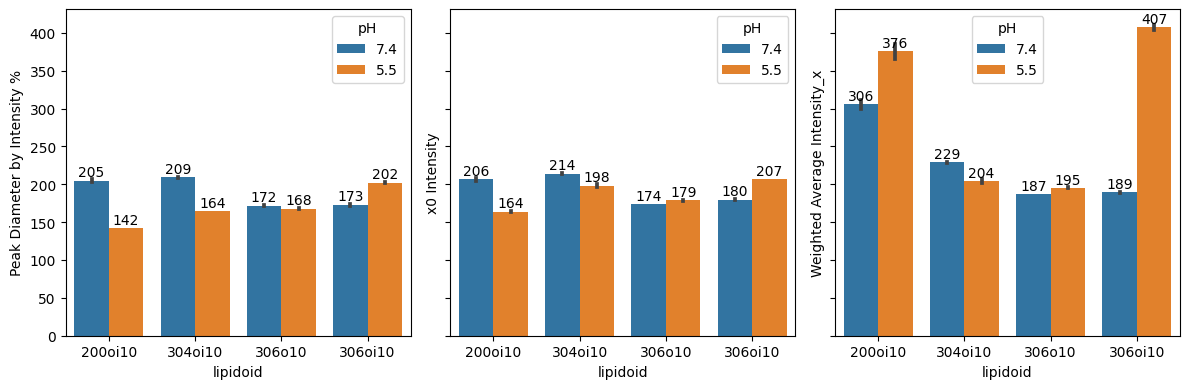

In [45]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

var_id = 0

for variable in ['Peak Diameter by Intensity %', 'x0 Intensity', 'Weighted Average Intensity_x']:

    # plot peak diameter by intensity
    sns.barplot(data=df_main.sort_values(by="lipidoid"),
                x="lipidoid",
                y=variable,
                hue="pH",
                ax=ax[var_id])
    
    for c in ax[var_id].containers:
        # set the bar label
        ax[var_id].bar_label(c, fmt='%.0f', label_type='edge', padding=1)

    #ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
    #ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
    #plt.xticks(rotation = 45)
    var_id += 1
    
    plt.tight_layout()

## Bargraph of x0 using fitted error bars

### Find one record number which is lipidoid 200oi10 and make a bar graph

In [46]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'LUV', 'LNP', 'fluorophore', 'lipid',
       'lipidoid', 'pH', 'Triton', 'Peak Diameter by Intensity %',
       'Peak Diameter by Number %', 'Weighted Average Intensity_x',
       'Weighted Average Number_x', 'Fitted Intensity %', 'Fitted Number %',
       'Weighted Average Intensity_y', 'Weighted Average Number_y',
       'a Intensity', 'log10 x0 Intensity', 'log10 sigma Intensity',
       'a Number', 'log10 x0 Number', 'log10 sigma Number', 'x0 Intensity',
       'sigma Intensity', 'lower Intensity', 'upper Intensity',
       'lower err Intensity', 'upper err Intensity', 'x0 Number',
       'sigma Number', 'lower Number', 'upper Number', 'lower err Number',
       'upper err Number'],
      dtype='object')

In [47]:
df_main.loc[df_main["Record Number"]==123].loc[:,["lipidoid","x0 Intensity","lower err Intensity","upper err Intensity"]].drop_duplicates().values

array([['200oi10', 265.48038280120454, 86.33603875945292,
        127.9444502811503]], dtype=object)

In [48]:
x = df_main.loc[df_main["Record Number"]==123].loc[:,"lipidoid"].drop_duplicates().values
y = df_main.loc[df_main["Record Number"]==123].loc[:,"x0 Intensity"].drop_duplicates().values
y = y[0]

yerr = df_main.loc[df_main["Record Number"]==123].loc[:,["lower err Intensity","upper err Intensity"]].drop_duplicates().values
yerr = yerr[0]
yerr = yerr.reshape(2,1)

In [49]:
print(x)
print(y)
print(yerr)

['200oi10']
265.48038280120454
[[ 86.33603876]
 [127.94445028]]


In [50]:
np.shape(yerr)

(2, 1)

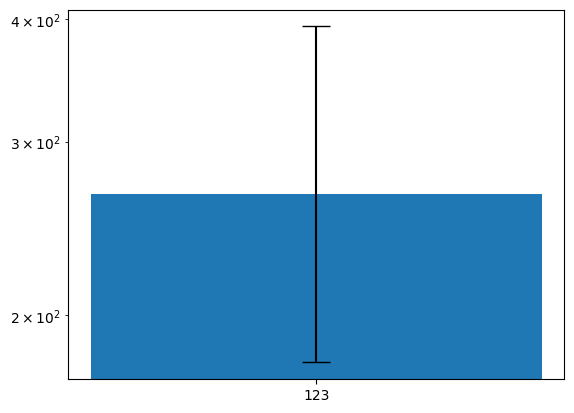

In [51]:
fig, ax = plt.subplots()

ax.bar(0, y, yerr=yerr, tick_label=123, capsize=10)
ax.set_yscale('log')

## one bar for each record number, different colors for pH

,Record Number,pH,title,Measurement Date and Time
8610,123,7.4,200oi10 LNP 0.5X,"Friday, February 24, 2023 9:43:28 AM"
8680,124,7.4,200oi10 LNP 0.5X,"Friday, February 24, 2023 9:45:40 AM"
8750,125,7.4,200oi10 LNP 0.5X,"Friday, February 24, 2023 9:47:53 AM"
9870,141,7.4,200oi10 LNP made 02-24-20,"Friday, February 24, 2023 10:09:59 PM"
9940,142,7.4,200oi10 LNP made 02-24-20,"Friday, February 24, 2023 10:12:22 PM"
10010,143,7.4,200oi10 LNP made 02-24-20,"Friday, February 24, 2023 10:14:44 PM"
10500,150,7.4,LNP 200oi10 10x diluted,"Monday, January 1, 2000 12:00:00 AM"
10570,151,7.4,LNP 200oi10 10x diluted,"Monday, January 1, 2000 12:00:00 AM"
10640,152,7.4,LNP 200oi10 10x diluted,"Monday, January 1, 2000 12:00:00 AM"
24360,371,7.4,200oi10 LNP - 10x dilution,"Monday, January 1, 2000 12:00:00 AM"


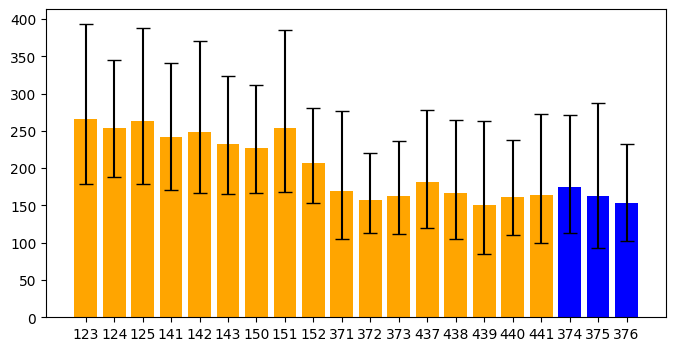

In [52]:
fig, ax = plt.subplots(figsize=(8,4))

x_start = 0

color_dict = {"5.5" : "blue",
              "7.4" : "orange"}

xticks = []
xticklabels = []

for pH in ["7.4","5.5"]:

    rn_list = df_main.loc[(df_main["lipidoid"]=="200oi10") &
                          (df_main["pH"] == pH)]["Record Number"].unique()
    x = x_start + np.arange(0,len(rn_list))
    y = df_main.loc[df_main["Record Number"].isin(rn_list)].loc[:,"x0 Intensity"].drop_duplicates().values
    yerr = df_main.loc[df_main["Record Number"].isin(rn_list)].loc[:,["lower err Intensity","upper err Intensity"]].drop_duplicates().values.T

    ax.bar(x, y, yerr=yerr, 
           tick_label=rn_list, 
           capsize=5,
           color=color_dict[pH])
    
    # reset
    x_start = np.max(x)+1
    xticks = np.append(xticks, ax.get_xticks())
    xticklabels = np.append(xticklabels, rn_list)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
...

# print all titles with rn
df_main.loc[df_main["lipidoid"]=="200oi10"].loc[:,["Record Number","pH","title","Measurement Date and Time"]].drop_duplicates()

In [53]:
# for each lipidoid, extract x0, and lower/upper sigma, and AVERAGE
pd.pivot_table(data=df_main,
               index=["lipidoid","pH"],
               values=["x0 Intensity","lower err Intensity","upper err Intensity"],
               aggfunc="mean")

lower err Intensity  upper err Intensity  x0 Intensity
lipidoid pH                                                         
200oi10  5.5            61.734747           100.200403    163.926603
         7.4            66.178685            98.797472    206.472347
304oi10  5.5            42.401508            55.660556    198.149537
         7.4            67.295487            98.829337    214.014347
306o10   5.5            57.888198            85.919249    178.996886
         7.4            55.878575            82.611765    173.830993
306oi10  5.5            71.369353           109.324475    206.804796
         7.4            51.529130            72.336952    179.633230

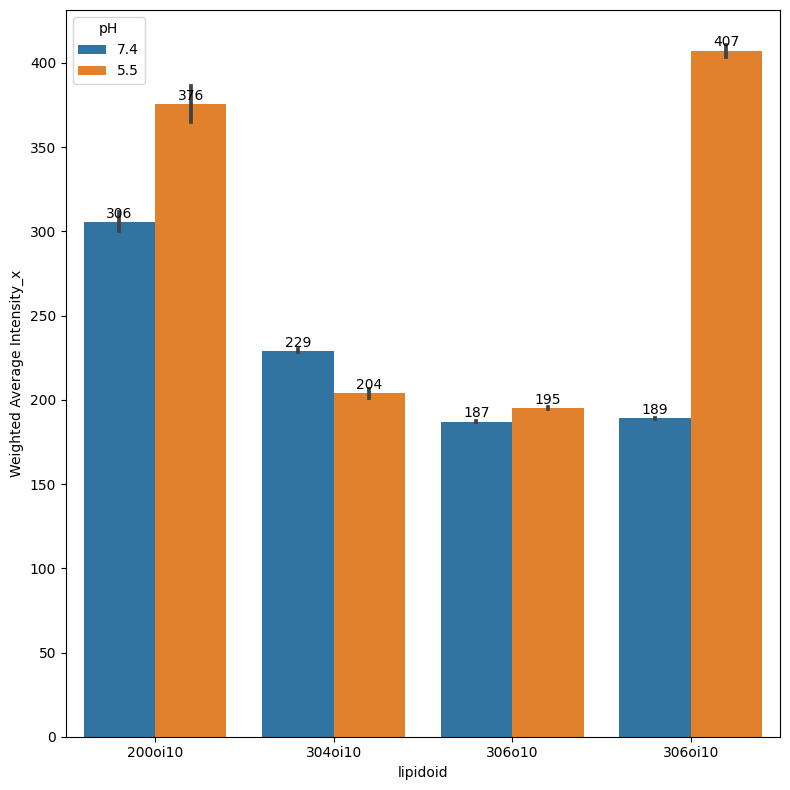

In [54]:
fig, ax = plt.subplots(1, figsize=(8,8))

# plot peak diameter by intensity

sns.barplot(data=df_main.sort_values(by="lipidoid"),
            x="lipidoid",
            y="Weighted Average Intensity_x",
            hue="pH",
            ax=ax)

for c in ax.containers:
    # set the bar label
    ax.bar_label(c, fmt='%.0f', label_type='edge', padding=1)

#ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
#ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
#plt.xticks(rotation = 45)
var_id += 1

plt.tight_layout()

# Plot spectra by lipidoid using seaborn

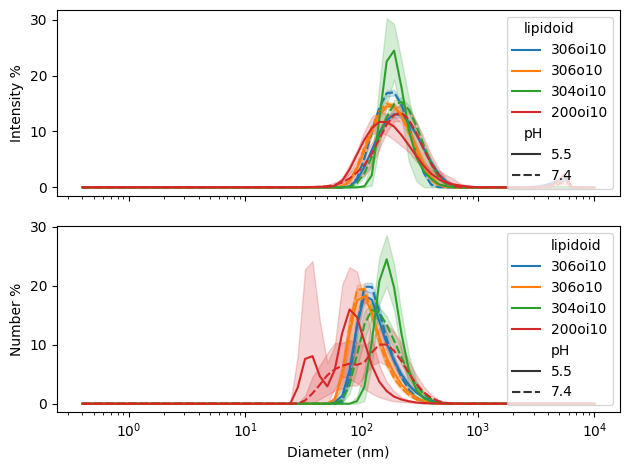

In [55]:
fig, ax = plt.subplots(2, sharex=True)

# plot intensity data

sns.lineplot(df_main,
             x="Diameter (nm)",
             y="Intensity %",
             hue="lipidoid",
             style="pH",
             ax=ax[0])

# plot number data

sns.lineplot(df_main,
             x="Diameter (nm)",
             y="Number %",
             hue="lipidoid",
             style="pH",
             ax=ax[1])

# format axes

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_ylabel('Intensity %')
ax[1].set_ylabel('Number %')

ax[0].set_xlabel('Diameter (nm)')

# format legend

ax[1].legend()

    
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


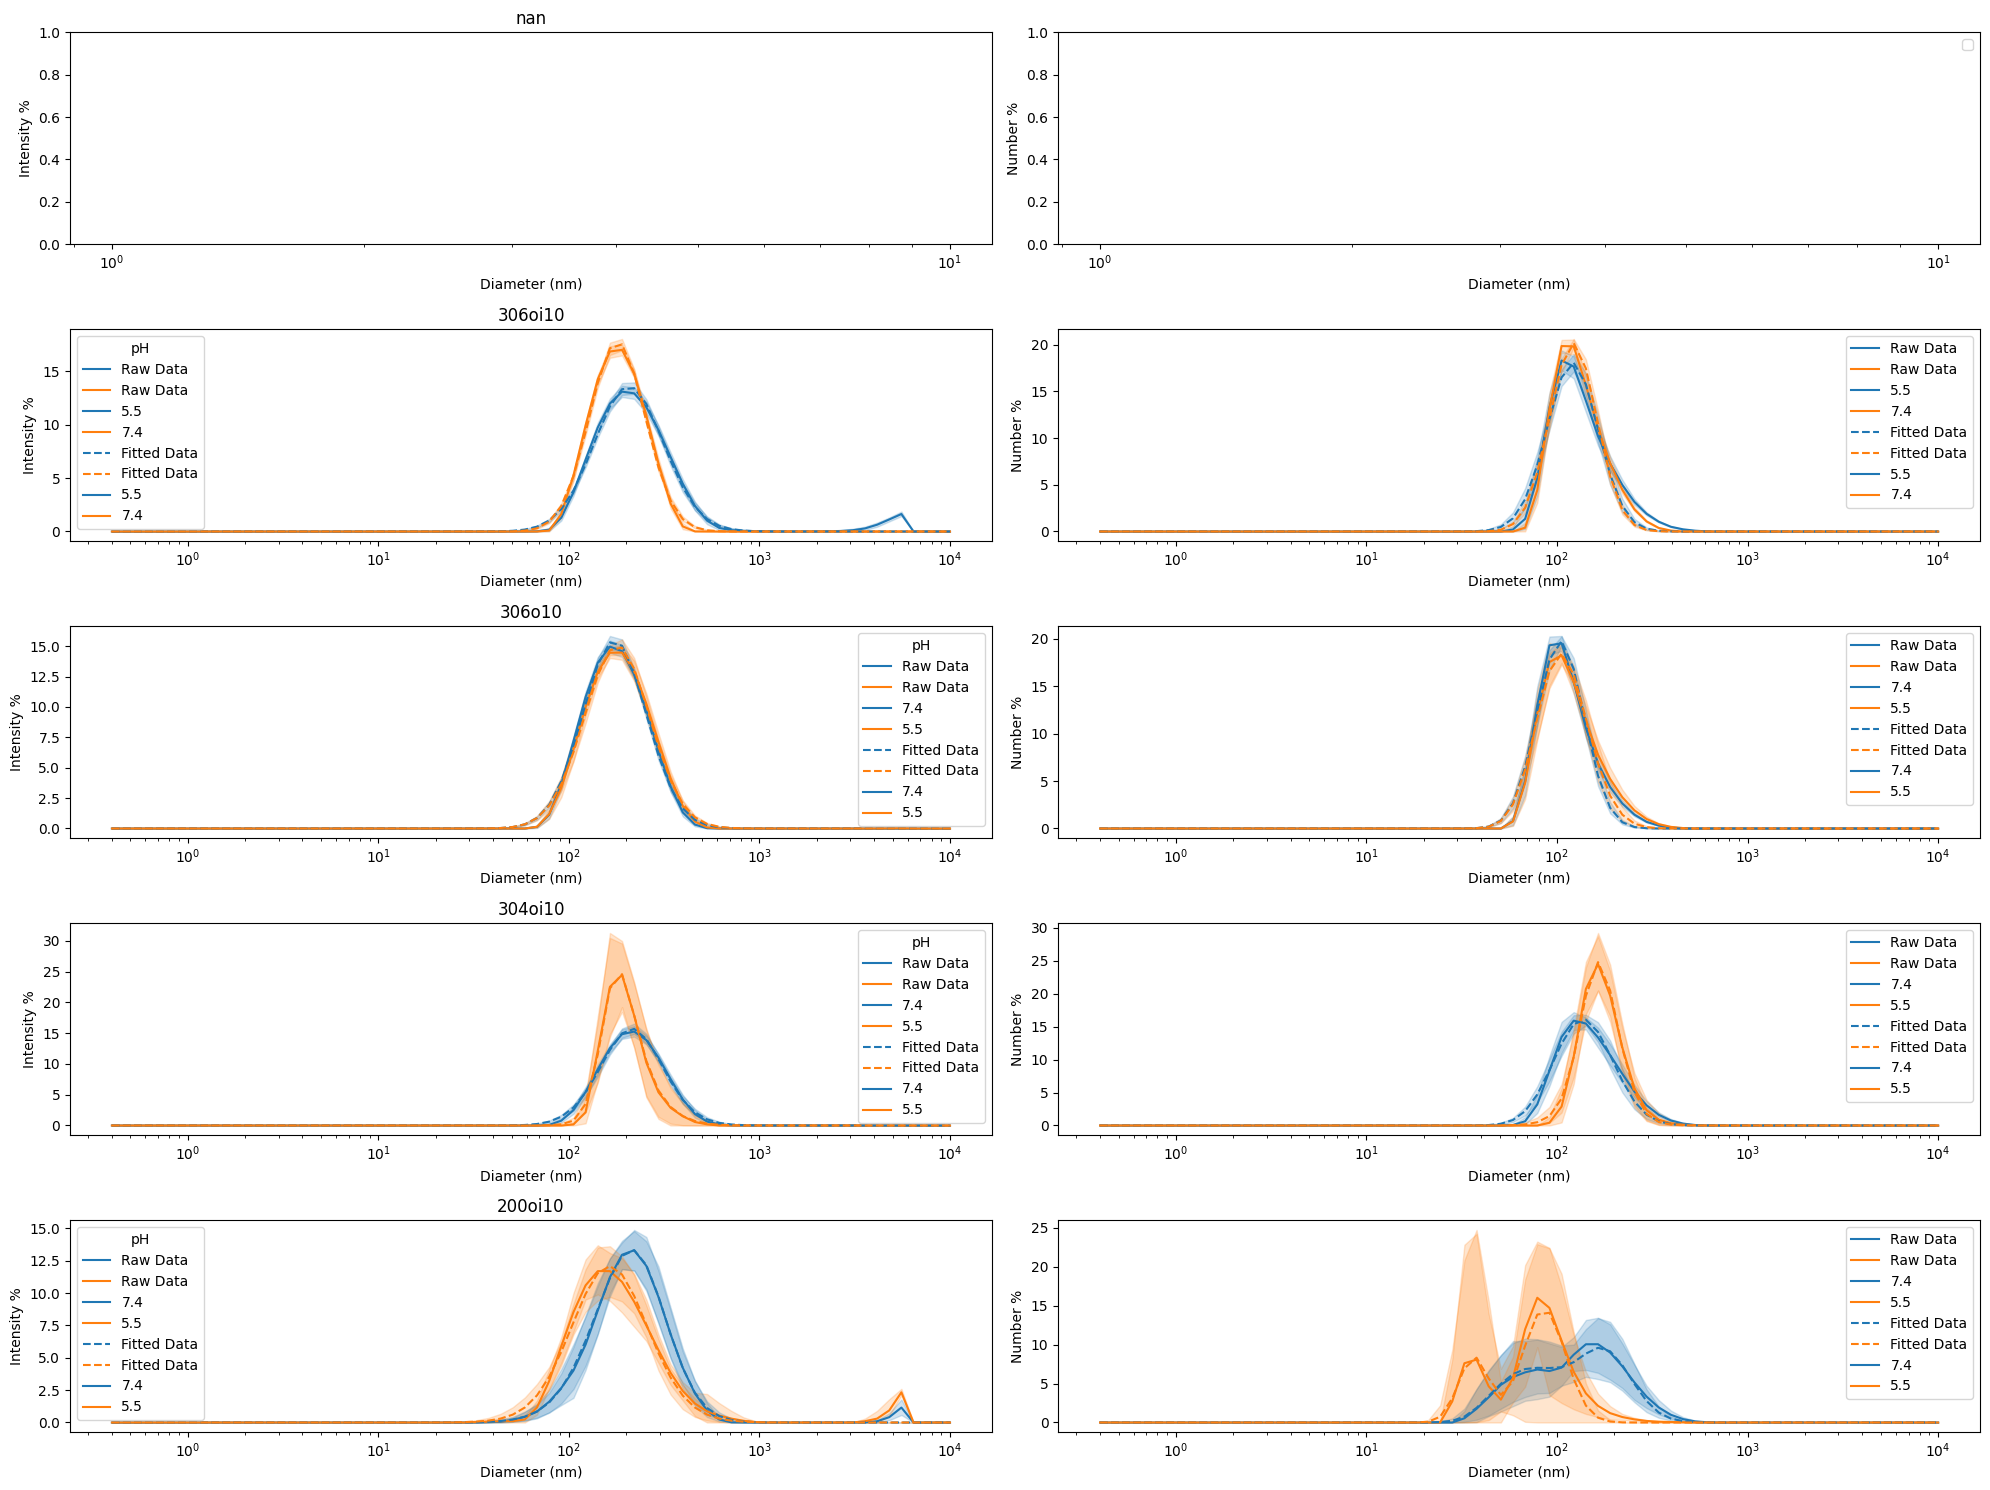

In [56]:
N = len(df_main["lipidoid"].unique())

fig, ax = plt.subplots(N,2, figsize=(20,N*3))

ax_id = 0

for lipidoid in df_main["lipidoid"].unique():
    
    # plot intensity data
    
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Intensity %",
                 label="Raw Data",
                 hue="pH",
                 ax=ax[ax_id,0])
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Fitted Intensity %",
                 label="Fitted Data",
                 hue="pH",
                 linestyle="dashed",
                 ax=ax[ax_id,0])

    # plot number data
    
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Number %",
                 label="Raw Data",
                 hue="pH",
                 ax=ax[ax_id,1])
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Fitted Number %",
                 label="Fitted Data",
                 hue="pH",
                 linestyle="dashed",
                 ax=ax[ax_id,1])

    # format axes
    
    ax[ax_id,0].set_xscale('log')
    ax[ax_id,1].set_xscale('log')
    
    ax[ax_id,0].set_title(lipidoid)
    
    ax[ax_id,0].set_ylabel('Intensity %')
    ax[ax_id,1].set_ylabel('Number %')
    
    ax[ax_id,0].set_xlabel('Diameter (nm)')
    ax[ax_id,1].set_xlabel('Diameter (nm)')
    
    # format legend
    
    ax[ax_id,1].legend()
    
    # format text
    '''
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))
    '''
    
    ax_id += 1
    
plt.tight_layout()

# Plot spectra by lipidoid using matplotlib

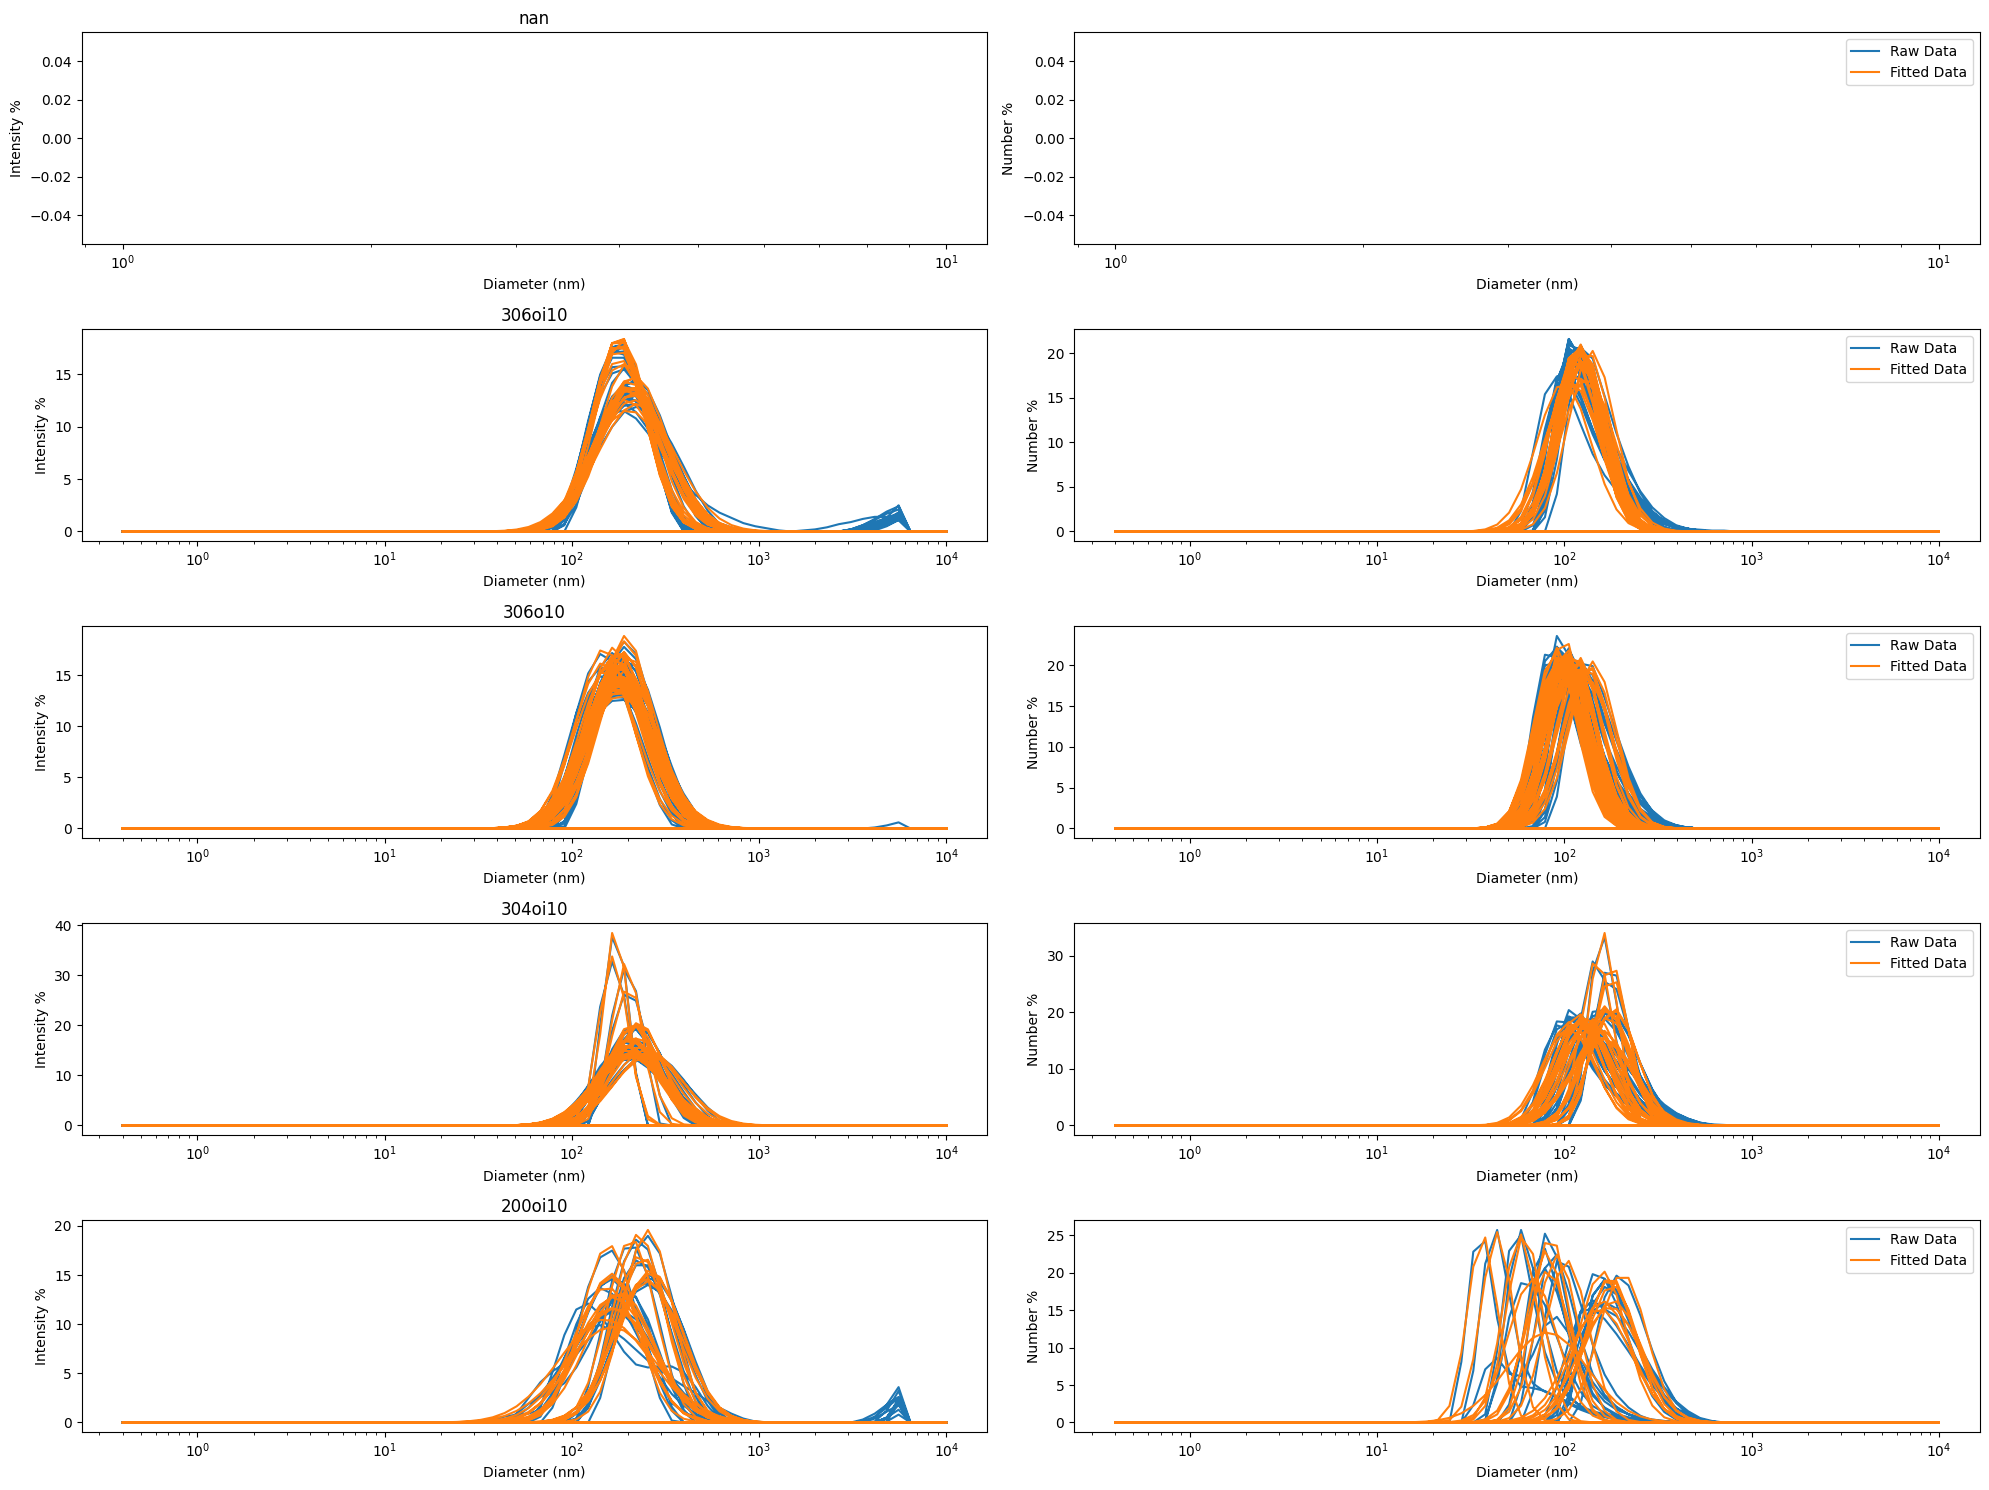

In [57]:
N = len(df_main["lipidoid"].unique())

fig, ax = plt.subplots(N,2, figsize=(20,N*3))

ax_id = 0

for lipidoid in df_main["lipidoid"].unique():
    
    # plot intensity data
    
    ax[ax_id,0].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                   df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Intensity %"],
                   label="Raw Data")
    ax[ax_id,0].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Fitted Intensity %"],
                  label="Fitted Data")
    
    # plot number data
    
    ax[ax_id,1].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Number %"],
                  label="Raw Data")
    ax[ax_id,1].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Fitted Number %"],
                  label="Fitted Data")

    # format axes
    
    ax[ax_id,0].set_xscale('log')
    ax[ax_id,1].set_xscale('log')
    
    ax[ax_id,0].set_title(lipidoid)
    
    ax[ax_id,0].set_ylabel('Intensity %')
    ax[ax_id,1].set_ylabel('Number %')
    
    ax[ax_id,0].set_xlabel('Diameter (nm)')
    ax[ax_id,1].set_xlabel('Diameter (nm)')
    
    # format legend
    
    ax[ax_id,1].legend()
    
    # format text
    '''
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))
    '''
    
    ax_id += 1
    
plt.tight_layout()

## Plot fitted and raw data for every record number

In [58]:
'''
N = len(df_main["Record Number"].unique())

fig, ax = plt.subplots(N,2, figsize=(8,N*4))

for rn in df_main["Record Number"].unique():
    
    # plot intensity data
    
    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Rrn*4ecord Number"]==rn].loc[:,"Intensity %"],
                  label="Raw Data")
    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Intensity %"],
                  label="Fitted Data")

    # plot number data
    
    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Number %"],
                  label="Raw Data")
    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Number %"],
                  label="Fitted Data")

    # format axes
    
    ax[rn-1,0].set_xscale('log')
    ax[rn-1,1].set_xscale('log')
    
    ax[rn-1,0].set_title('Record Number '+str(rn))
    
    ax[rn-1,0].set_ylabel('Intensity %')
    ax[rn-1,1].set_ylabel('Number %')
    
    ax[rn-1,0].set_xlabel('Diameter (nm)')
    ax[rn-1,1].set_xlabel('Diameter (nm)')
    
    # format text
    
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))

    plt.tight_layout()
'''

'\nN = len(df_main["Record Number"].unique())\n\nfig, ax = plt.subplots(N,2, figsize=(8,N*4))\n\nfor rn in df_main["Record Number"].unique():\n    \n    # plot intensity data\n    \n    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],\n                  df_main.loc[df_main["Rrn*4ecord Number"]==rn].loc[:,"Intensity %"],\n                  label="Raw Data")\n    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],\n                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Intensity %"],\n                  label="Fitted Data")\n\n    # plot number data\n    \n    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],\n                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Number %"],\n                  label="Raw Data")\n    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],\n                  df_main.loc[df_main["Record Number"]==rn].loc[:,"

#  Plot specific items

# R18 POPC LUV by pH

In [59]:
keeptitles = ["R18 POPC LUV pH 5.5 0.05X",
              "R18 POPC LUV pH 7.4 0.025X"]
             #"R18 POPC LUV 0.01X",]

In [60]:
df_keep = df_main.loc[df_main["title"].isin(keeptitles)]

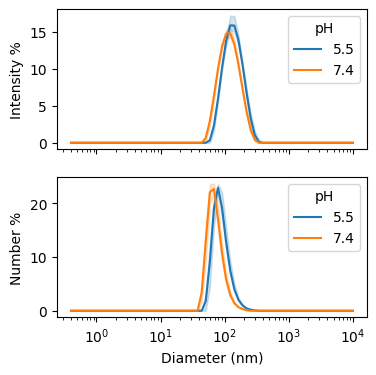

In [61]:
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True)

sns.lineplot(data=df_keep,
             x="Diameter (nm)",
             y="Intensity %",
             hue="pH",
             ax=ax[0])

sns.lineplot(data=df_keep,
             x="Diameter (nm)",
             y="Number %",
             hue="pH",
             ax=ax[1])

ax[0].set_xscale('log')

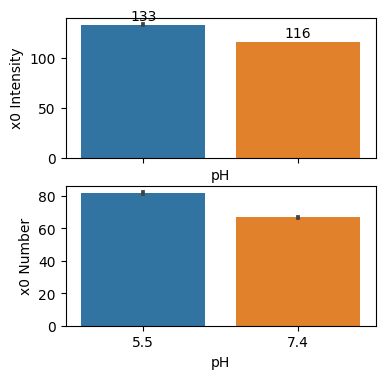

In [62]:
fig, ax = plt.subplots(2,1, figsize=(4,4), sharex=True)

sns.barplot(data=df_keep,
             x="pH",
             y="x0 Intensity",
             ax=ax[0])

sns.barplot(data=df_keep,
             x="pH",
             y="x0 Number",
             ax=ax[1])

for c in ax[0].containers:
    # set the bar label
    ax[0].bar_label(c, fmt='%.0f', label_type='edge', padding=1)


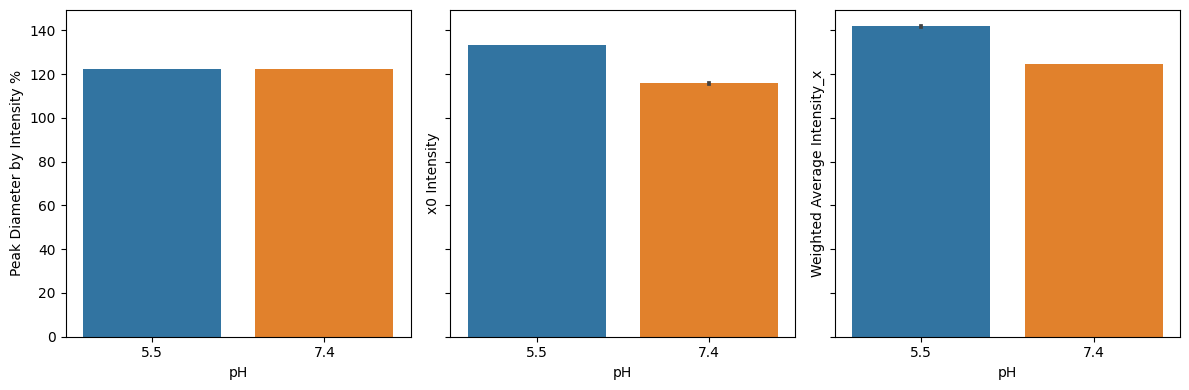

In [63]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

var_id = 0

for variable in ['Peak Diameter by Intensity %', 'x0 Intensity', 'Weighted Average Intensity_x']:

    # plot peak diameter by intensity
    sns.barplot(data=df_keep,
                x="pH",
                y=variable,
               ax=ax[var_id])

    #ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
    #ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
    #plt.xticks(rotation = 45)
    var_id += 1
    
    plt.tight_layout()